In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from sklearn.model_selection import cross_val_predict

## Initial dataframe import

In [2]:
inspire=pd.read_pickle('./datfiles/INSPIREpy2.df')

#get ngram totals
titlegrams = ['title unigrams', 'title bigrams', 'title trigrams', 'title quadgrams'] 
abstractgrams = ['abstract unigrams', 'abstract bigrams', 'abstract trigrams', 'abstract quadgrams']
inspire['title total']= inspire[titlegrams].sum(axis=1)
inspire['abstract total']= inspire[abstractgrams].sum(axis=1)

#get rid of some failed extractions
inspire['f_core_2o']=inspire['f_core_2o'].replace(-1,0)
inspire['f_noncore_2o']=inspire['f_noncore_2o'].replace(-1,0)

#shuffle data
inspire=inspire.reindex(np.random.permutation(inspire.index)) 
inspire=inspire.reset_index(drop=True)
inspire.head()

,coreness,texts,title unigrams,title bigrams,title trigrams,title quadgrams,abstract unigrams,abstract bigrams,abstract trigrams,abstract quadgrams,category,f_core,f_noncore,f_core_2o,f_noncore_2o,Nrefs,title total,abstract total
0,0,Thin Sequences and Their Role in Model Spaces ...,1,0,0,0,2,0,0,0,math.CV,0.000000,0.000000,0.00000,0.00000,26.0,1,2
1,0,On replica symmetry of large deviations in ran...,2,0,0,0,0,0,0,0,math.PR,0.000000,0.000000,0.00000,0.00000,47.0,2,0
2,2,Graphical Tensor Product Reduction Scheme for ...,2,0,0,4,6,0,0,4,math-ph,0.653846,0.115385,0.46907,0.08173,26.0,6,10
3,2,Hamiltonian analysis of the BFCG theory for th...,3,0,0,0,11,0,0,0,gr-qc,0.666667,0.133333,0.49273,0.09612,15.0,3,11
4,0,Chip firing on Dynkin diagrams and McKay quive...,0,0,0,0,5,0,0,0,math.CO,0.000000,0.027778,0.00000,0.00595,36.0,0,5


In [3]:
#split dataframe into training/validation/test 
training_samples = 3 * len(inspire) // 5
validation_samples = len(inspire) // 5

inspire_train = inspire[:training_samples]
inspire_val = inspire[training_samples:training_samples + validation_samples]
inspire_test = inspire[training_samples + validation_samples:]

In [4]:
# funtion to plot confusion matrices, will be needed later
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
class_names = ["Rejected", "Non-Core", "Core"]

## DICTIONARY OF KEYWORDS

In [7]:
ngrams = ['title unigrams', 'title bigrams', 'title trigrams', 'title quadgrams', 'abstract unigrams', 'abstract bigrams', 'abstract trigrams', 'abstract quadgrams','title total','abstract total']
svc_ngram = svm.SVC(decision_function_shape='ovo', kernel='rbf', class_weight='balanced')
SVC_ngram = svc_ngram.fit(inspire_train[ngrams], inspire_train['coreness'])

In [8]:
y_pred_ngram = SVC_ngram.predict(inspire_val[ngrams])
print ('SVC ngram accuracy:', SVC_ngram.score(inspire_val[ngrams], inspire_val['coreness']))

('SVC ngram accuracy:', 0.66057794529815406)


Normalized confusion matrix
[[ 0.71  0.19  0.1 ]
 [ 0.28  0.36  0.36]
 [ 0.16  0.27  0.57]]


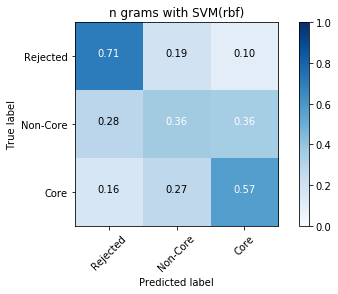

In [9]:
# Compute confusion matrix
cm_ngram = confusion_matrix(inspire_val['coreness'], y_pred_ngram)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_ngram, classes=class_names, normalize=True,
                      title='n grams with SVM(rbf)')
plt.show()

## BAG OF WORDS

In [24]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import model_selection

In [25]:
# outputs various scores, including f1 score
# then plots confusion matrix
def Analyze(classifier,X_train,Y_train,X_test,Y_test):
    clf=classifier.fit(X_train,Y_train)
   # score=clf.score(X_test,Y_test)
    Y_pred=clf.predict(X_test)
    target_names=['Rejected','NON-CORE','CORE']
    target_labels=[0,1,2]
    report=classification_report(Y_test,Y_pred,labels=target_labels,target_names=target_names)
    cm=cm=confusion_matrix(Y_test,Y_pred,labels=[0,1,2])
    plt.figure()
    plot_confusion_matrix(cm,classes=target_names,normalize=True)
    plt.show()
    print(report)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [27]:
# tests various models
def modeltesting(X_train, X_validation, Y_train, Y_validation):
    '''Function to test different models and produce a box plot to show the accuracies'''
    scoring = 'accuracy'
    # Spot Check Algorithms
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    #models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    #models.append(('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()))
    #models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    #models.append(('Naive Bayes', GaussianNB()))
    #models.append(('Neural Network', MLPClassifier()))
    models.append(('LinearSVC', LinearSVC(max_iter=10,class_weight='balanced')))
    models.append(('SGDClassifier', SGDClassifier(max_iter=10,class_weight='balanced',loss='log',penalty='elasticnet')))
    #models.append(('SVC', SVC(class_weight='balanced')))
    
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=42)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())    
        print(msg)
        Analyze(model,X_train,Y_train,X_validation,Y_validation)
        
    fig = plt.figure()
    #fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    #pyplot.legend()
    plt.ylabel('Accuracy')
    ax.set_xticklabels(names,rotation=13)
    plt.show()

In [28]:
x_train_text = inspire_train['texts']
x_val_text = inspire_val['texts']
x_test_text = inspire_test['texts']

y_train = inspire_train['coreness']
y_val = inspire_val['coreness']
y_test = inspire_test['coreness']

In [29]:
# vectorises (this will also remove common words)/ performs tfidf on text 
count_vec=CountVectorizer(stop_words='english')
X_train_counts=count_vec.fit_transform(x_train_text)
X_val_counts=count_vec.transform(x_val_text)
X_test_counts=count_vec.transform(x_test_text)
    
tfidf_transformer = TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)
X_val_tfidf= tfidf_transformer.fit_transform(X_val_counts)
X_test_tfidf= tfidf_transformer.transform(X_test_counts)

LogisticRegression: 0.909958 (0.005701)
Normalized confusion matrix
[[ 0.99  0.01  0.  ]
 [ 0.54  0.36  0.1 ]
 [ 0.17  0.03  0.8 ]]


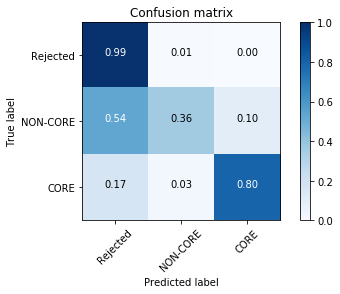

             precision    recall  f1-score   support

   Rejected       0.92      0.99      0.95      8066
   NON-CORE       0.77      0.36      0.49       856
       CORE       0.92      0.80      0.85      1425

avg / total       0.91      0.91      0.90     10347

DecisionTreeClassifier: 0.872555 (0.004383)
Normalized confusion matrix
[[ 0.94  0.03  0.03]
 [ 0.42  0.4   0.18]
 [ 0.15  0.09  0.76]]


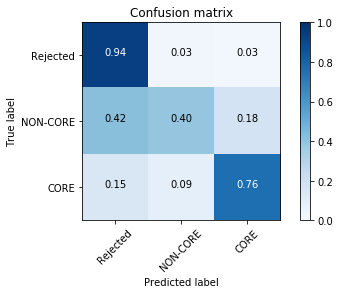

             precision    recall  f1-score   support

   Rejected       0.93      0.94      0.93      8066
   NON-CORE       0.46      0.40      0.43       856
       CORE       0.75      0.76      0.75      1425

avg / total       0.87      0.87      0.87     10347

LinearSVC: 0.919172 (0.003598)
Normalized confusion matrix
[[ 0.97  0.02  0.01]
 [ 0.32  0.55  0.12]
 [ 0.08  0.07  0.86]]


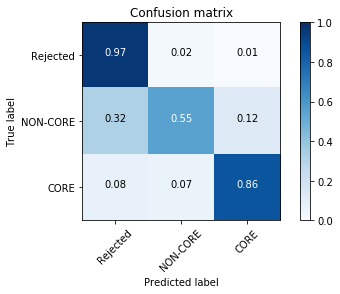

             precision    recall  f1-score   support

   Rejected       0.95      0.97      0.96      8066
   NON-CORE       0.64      0.55      0.59       856
       CORE       0.88      0.86      0.87      1425

avg / total       0.92      0.92      0.92     10347

SGDClassifier: 0.909925 (0.005885)
Normalized confusion matrix
[[ 0.97  0.02  0.01]
 [ 0.38  0.52  0.1 ]
 [ 0.13  0.07  0.8 ]]


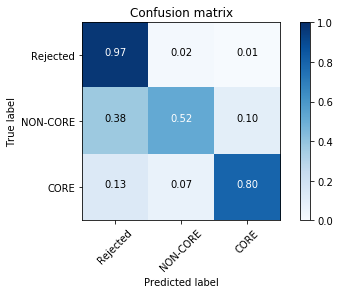

             precision    recall  f1-score   support

   Rejected       0.94      0.97      0.95      8066
   NON-CORE       0.61      0.52      0.56       856
       CORE       0.89      0.80      0.84      1425

avg / total       0.91      0.91      0.91     10347



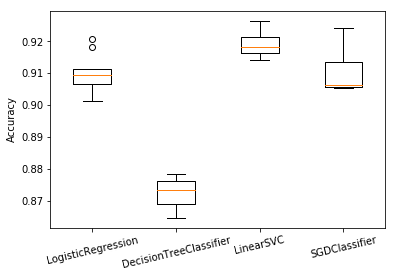

In [30]:
# depending on how many models you are testing this can take a while
modeltesting(X_train_tfidf, X_val_tfidf, y_train, y_val)

## WORD EMBEDDINGS

In [23]:
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Flatten, Input, LSTM, concatenate
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import tensorflow as tf

from sklearn.utils import class_weight
from sklearn.metrics import cohen_kappa_score, accuracy_score

/Users/parisa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
# tokenises the text 
texts= inspire['texts']
tokenizer = Tokenizer(num_words=10000) # takes "num_words" most common tokens
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
token_data = pad_sequences(sequences, maxlen=220)  # takes first "maxlen" number of words from text
labels = to_categorical(inspire['coreness'], num_classes=3)

In [25]:
# split into train/ val/ test
x_train_embed = token_data[:training_samples]
y_train_embed = labels[:training_samples]

x_val_embed = token_data[training_samples:training_samples + validation_samples]
y_val_embed = labels[training_samples:training_samples + validation_samples]

x_test_embed = token_data[training_samples + validation_samples:]
y_test_embed = labels[training_samples + validation_samples:]

# Neural Network with embeddings layer

In [26]:
model1 = Sequential()
model1.add(Embedding(10000, 100, input_length=220))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(3, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 220, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 22000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                704032    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 1,706,243
Trainable params: 1,706,243
Non-trainable params: 0
_________________________________________________________________


In [27]:
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [28]:
class_weights = class_weight.compute_class_weight('balanced',[0,1,2],inspire['coreness'])

history1 = model1.fit(x_train_embed, y_train_embed, epochs=5, batch_size=50, class_weight=class_weights, validation_data=(x_val_embed, y_val_embed),verbose=2)

Train on 31041 samples, validate on 10347 samples
Epoch 1/5
 - 20s - loss: 0.3498 - acc: 0.8743 - val_loss: 0.2760 - val_acc: 0.9033
Epoch 2/5
 - 19s - loss: 0.1574 - acc: 0.9455 - val_loss: 0.2990 - val_acc: 0.9033
Epoch 3/5
 - 20s - loss: 0.0363 - acc: 0.9880 - val_loss: 0.5056 - val_acc: 0.8998
Epoch 4/5
 - 19s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.8288 - val_acc: 0.8957
Epoch 5/5
 - 19s - loss: 0.0012 - acc: 0.9995 - val_loss: 1.0408 - val_acc: 0.8978


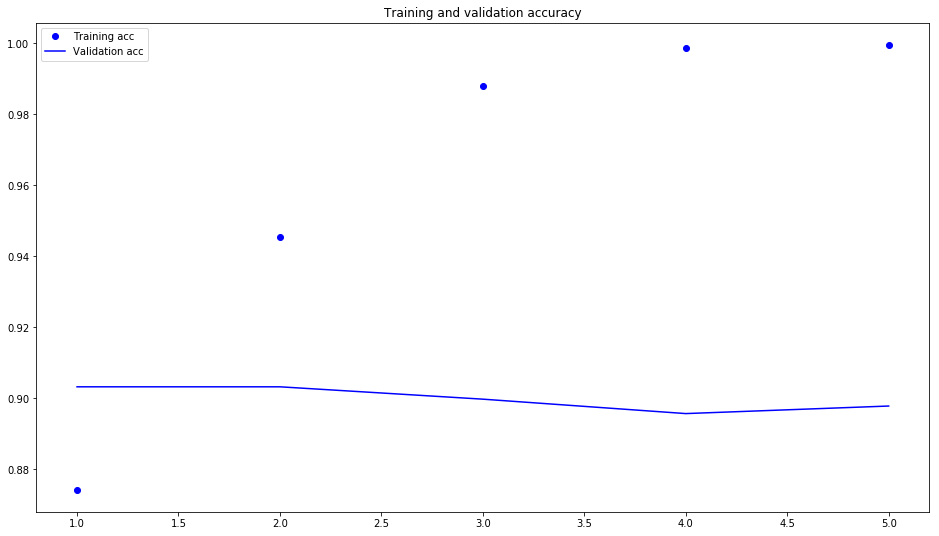

In [29]:
acc_model1 = history1.history['acc']
val_acc_model1 = history1.history['val_acc']

epochs = range(1, len(acc_model1) + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, acc_model1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_model1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [30]:
_, acc_model1 = model1.evaluate(x_val_embed, y_val_embed)

10347/10347 [==============================] - 1s 139us/step


In [31]:
print ('Accuracy:',acc_model1)

Accuracy: 0.8978447859282884


In [32]:
# output accuracy/ cohen kappa for model 
probs_embed = model1.predict(x_val_embed,batch_size=32)
pred_embed = np.argmax(probs_embed,axis=1)
true_embed = np.argmax(y_val_embed,axis=1)
cohen_kappa1= cohen_kappa_score(true_embed,pred_embed)
accuracy1= accuracy_score(true_embed, pred_embed)
print('accuracy:', accuracy1)
print('cohen kappa score:', cohen_kappa1)

accuracy: 0.8978447859282884
cohen kappa score: 0.6845701048095192


In [33]:
# make confusion matrix in keras
cm_embed=tf.confusion_matrix(
    labels=true_embed,
    predictions=pred_embed,
    num_classes=3,
    dtype=tf.int32,
    name=None,
    weights=None
)
with tf.Session():
   m=tf.Tensor.eval(cm_embed,feed_dict=None, session=None)

Normalised confusion matrix:
Normalized confusion matrix
[[0.98 0.01 0.01]
 [0.57 0.28 0.16]
 [0.16 0.06 0.79]]


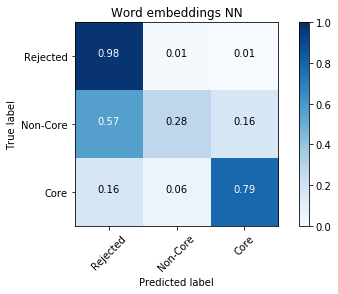

In [34]:
print('Normalised confusion matrix:')
plt.figure()
plot_confusion_matrix(m,classes=class_names,normalize=True,title='Word embeddings NN')
#plt.savefig('CM_NeuralNet',pad_inches=0.2,dpi=200,bbox_inches='tight')
plt.show()

# Neural Network with word embedding layer and reference fractions as an auxiliary input

In [35]:
# choosing 4 fractions
ref1_cols=['f_core', 'f_noncore', 'f_core_2o',  'f_noncore_2o']

x_train_ref1 = inspire_train[ref1_cols]
x_val_ref1 = inspire_val[ref1_cols]
x_test_ref1 = inspire_test[ref1_cols]

In [36]:
main_input= Input(shape=(220,),name='main_input')     # input from text tokens
x= Embedding(10000, 100, input_length=220)(main_input)
#x = Dense(50, activation='relu')(x)
lstm_out=LSTM(50)(x)
auxiliary_output=Dense(3, activation='softmax', name='aux_out')(lstm_out)
#print (auxiliary_output.shape)

auxiliary_input= Input(shape=(4,), name='aux_input')     # input from fractions
x= concatenate([lstm_out, auxiliary_input])
x = Dense(3, activation='relu')(x)
#x = Dense(50, activation='relu')(x)
#x = Dense(20, activation='relu')(x)
main_output= Dense(3,activation='softmax', name='main_output')(x)

In [37]:
model2 = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 220, 100)     1000000     main_input[0][0]                 
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           30200       embedding_2[0][0]                
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 4)            0                                            
__________________________________________________________________________________________________
concatenat

In [38]:
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', loss_weights=[1,0.5],metrics=['acc'])

In [39]:
# this can take a while
history2= model2.fit([x_train_embed, x_train_ref1],[y_train_embed, y_train_embed],validation_data=([x_val_embed, x_val_ref1], [y_val_embed, y_val_embed]),epochs=10,batch_size=50,class_weight=[class_weight,class_weight],verbose=2)

Train on 31041 samples, validate on 10347 samples
Epoch 1/10
 - 174s - loss: 0.6761 - main_output_loss: 0.4692 - aux_out_loss: 0.4140 - main_output_acc: 0.8629 - aux_out_acc: 0.8622 - val_loss: 0.4947 - val_main_output_loss: 0.3243 - val_aux_out_loss: 0.3408 - val_main_output_acc: 0.8947 - val_aux_out_acc: 0.8936
Epoch 2/10
 - 171s - loss: 0.4148 - main_output_loss: 0.2684 - aux_out_loss: 0.2927 - main_output_acc: 0.9003 - aux_out_acc: 0.8957 - val_loss: 0.4660 - val_main_output_loss: 0.2925 - val_aux_out_loss: 0.3471 - val_main_output_acc: 0.9036 - val_aux_out_acc: 0.8621
Epoch 3/10
 - 187s - loss: 0.3552 - main_output_loss: 0.2232 - aux_out_loss: 0.2639 - main_output_acc: 0.9169 - aux_out_acc: 0.9057 - val_loss: 0.3861 - val_main_output_loss: 0.2445 - val_aux_out_loss: 0.2833 - val_main_output_acc: 0.9207 - val_aux_out_acc: 0.9097
Epoch 4/10
 - 181s - loss: 0.3132 - main_output_loss: 0.1944 - aux_out_loss: 0.2377 - main_output_acc: 0.9308 - aux_out_acc: 0.9159 - val_loss: 0.3392 - va

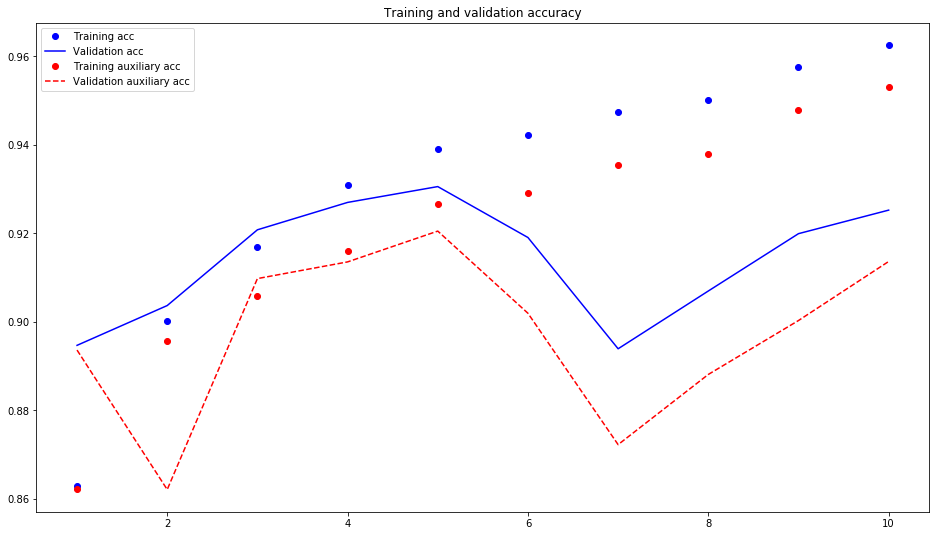

In [40]:
acc_model2 = history2.history['main_output_acc']
val_acc_model2 = history2.history['val_main_output_acc']

aux_acc_model2 = history2.history['aux_out_acc']
aux_val_acc_model2 = history2.history['val_aux_out_acc']

epochs = range(1, len(acc_model2) + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, acc_model2, 'bo', label='Training acc')
plt.plot(epochs, val_acc_model2, 'b', label='Validation acc')
plt.plot(epochs, aux_acc_model2, 'bo', label='Training auxiliary acc',c='r')
plt.plot(epochs, aux_val_acc_model2, 'b', label='Validation auxiliary acc',linestyle='--',c='r')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [41]:
probs2 = model2.predict([x_val_embed,x_val_ref1],batch_size=32)
pred2 = np.argmax(probs2,axis=2)[1]
true2 = np.argmax(y_val_embed,axis=1)
cohen_kappa2= cohen_kappa_score(true2,pred2)
accuracy2= accuracy_score(true2, pred2)
print('accuracy:', accuracy2)
print('cohen kappa score:', cohen_kappa2)

accuracy: 0.9135981443896781
cohen kappa score: 0.7527817808368329


In [42]:
cm_embed2=tf.confusion_matrix(
    labels=true2,
    predictions=pred2,
    num_classes=3,
    dtype=tf.int32,
    name=None,
    weights=None
)
with tf.Session():
   m2=tf.Tensor.eval(cm_embed2,feed_dict=None, session=None)

Normalised confusion matrix:
Normalized confusion matrix
[[0.97 0.02 0.02]
 [0.38 0.39 0.23]
 [0.06 0.03 0.91]]


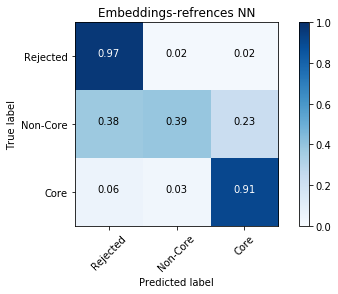

In [43]:
print('Normalised confusion matrix:')
plt.figure()
plot_confusion_matrix(m2,classes=class_names,normalize=True,title='Embeddings-refrences NN')
#plt.savefig('CM_NeuralNet_refs',pad_inches=0.2,dpi=200,bbox_inches='tight')
plt.show()

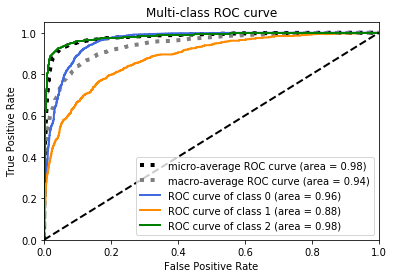

In [44]:
# Compute macro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
# First aggregate all false positive rates
n_classes=3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_embed[:, i], probs2[1][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_embed.ravel(), probs2[1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='k', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='grey', linestyle=':', linewidth=4)

colors = cycle(['royalblue', 'darkorange', 'g'])
for i, color in zip(range(n_classes), colors):
    lw = 2
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()

## SVM WITH FRACTIONS

In [45]:
inputs = ['f_core', 'f_noncore', 'f_core_2o',  'f_noncore_2o']
svc_refs = svm.SVC(decision_function_shape='ovr', kernel='linear' ,class_weight='balanced', probability=False)

In [46]:
# train svm
SVC_refs = svc_refs.fit(inspire_train[inputs], inspire_train['coreness'])
print (SVC_refs.score(inspire_val[inputs], inspire_val['coreness']))

0.8748429496472407


In [47]:
# print decision function
dec = SVC_refs.decision_function(inspire_val[inputs]) # distances from each decision boundary
print (dec)

[[ 2.05  1.   -0.05]
 [ 2.05  1.   -0.05]
 [ 0.97  2.09 -0.06]
 ...
 [ 2.05  1.   -0.05]
 [ 2.04  1.01 -0.05]
 [ 2.05  1.   -0.05]]


In [48]:
# convert to a distance
w_norm = np.linalg.norm(SVC_refs.coef_,axis=1)  # turn 4x3 matrix of N_feat*N_categories into 1*3 of N_categories
dist = dec / w_norm # normalise the distsances by the normed nweights

Normalized confusion matrix
[[0.9  0.1  0.  ]
 [0.22 0.69 0.09]
 [0.03 0.11 0.86]]


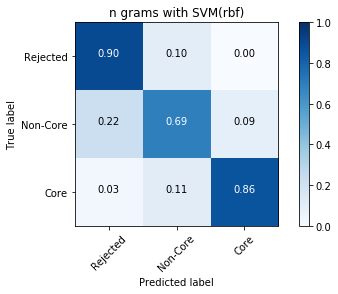

In [49]:
#make prediction
y_pred_refs = SVC_refs.predict(inspire_val[inputs])

# Compute confusion matrix
cm_refs = confusion_matrix(inspire_val['coreness'], y_pred_refs)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_refs, classes=class_names, normalize=True,
                      title='Lin SVM with refernce fractions')
plt.show()

## 2 CLASSIFIERS (REJ/NC/CORE - CHECK/AUTO)

In [6]:
# create column for just bi, tri and quad grams
inspire['234']=inspire['title bigrams']+inspire['title trigrams']+inspire['title quadgrams'] + inspire['abstract bigrams']+ inspire['abstract trigrams']+ inspire['abstract quadgrams']

In [7]:
# you can succesfully train R/NC/C classifier with less data and still end up with the same result
# since here we will need more training data for the 2nd classifier (the validation data for the first) we will do this
training_samples_2c = 4 * len(inspire) // 10
validation_samples_2c = 3 * len(inspire) // 10

inspire_train_2c = inspire[:training_samples_2c]
inspire_val_2c = inspire[training_samples_2c:training_samples_2c + validation_samples_2c].reset_index(drop=True)
inspire_test_2c = inspire[training_samples_2c + validation_samples_2c:].reset_index(drop=True)

In [8]:
# first classifier
svc_refs_2c = svm.SVC(decision_function_shape='ovr', kernel='linear' ,class_weight='balanced', probability=False)

In [9]:
#  train classifier 1
inputs = ['f_core', 'f_noncore', 'f_core_2o',  'f_noncore_2o']
SVC_refs_2c = svc_refs_2c.fit(inspire_train_2c[inputs], inspire_train_2c['coreness'])
print (SVC_refs_2c.score(inspire_val_2c[inputs], inspire_val_2c['coreness']))

0.884020618557


In [10]:
# find distance for this classifier
dec_2c = SVC_refs_2c.decision_function(inspire_val_2c[inputs])
w_norm_2c = np.linalg.norm(SVC_refs_2c.coef_, axis=1)
dist_2c = dec_2c / w_norm_2c

make a check and decision distance column

In [11]:
# make a column in the validation data that tells us if the svm predicted the paper correctly
# this will tell us if we need to check the paper
y_pred_2c = SVC_refs_2c.predict(inspire_val_2c[inputs])
y_pred_2c.reshape(15520,1)
inspire_val_2c['y_pred'] = y_pred_2c

check = np.asarray(inspire_val_2c['coreness']-inspire_val_2c['y_pred'])
Check = []
for x in check:
    if (x == 0):
        Check = np.append(Check, 1)
    else:
        Check = np.append(Check, 0)
inspire_val_2c['Check'] = Check

In [12]:
# create a column that tells us the distance from the boundary
cols  = ['A', 'B', 'C']
probs = pd.DataFrame(dist_2c, columns=cols)

A = np.asarray(probs['A'])
B = np.asarray(probs['B'])
C = np.asarray(probs['C'])

Ypred = np.asarray(inspire_val_2c['y_pred'])
Decision = []
for x, value in enumerate(Ypred):
    if (value == 0):
        Decision = np.append(Decision,(A[x]))
    elif (value == 1):
        Decision = np.append(Decision,(B[x]))
    elif (value == 2):
        Decision = np.append(Decision,(C[x]))

inspire_val_2c['Decision']  = Decision

In [13]:
inspire_val_2c.head()

,coreness,texts,title unigrams,title bigrams,title trigrams,title quadgrams,abstract unigrams,abstract bigrams,abstract trigrams,abstract quadgrams,...,f_noncore,f_core_2o,f_noncore_2o,Nrefs,title total,abstract total,234,y_pred,Check,Decision
0,0,Saturated simple and 2-simple topological grap...,2,0,0,0,7,0,0,0,...,0.000000,0.00000,0.00000,5.0,2,7,0,0,1.0,0.206281
1,0,Combat Models for RTS Games Game tree search a...,0,0,0,0,1,1,0,0,...,0.000000,0.00000,0.00000,28.0,0,2,1,0,1.0,0.206281
2,2,Universal Lie Formulas for Higher Antibrackets...,1,0,0,0,4,0,0,0,...,0.133333,0.34753,0.07726,30.0,1,4,0,2,1.0,0.481328
3,0,Tilting theory for trees via stable homotopy t...,1,0,0,0,6,0,0,0,...,0.000000,0.00000,0.00000,39.0,1,6,0,0,1.0,0.206281
4,2,To which densities is spin-polarized neutron m...,2,1,0,0,11,2,1,0,...,0.565217,0.35581,0.44580,46.0,3,14,4,1,0.0,0.214486


In [14]:
# split the validation data from SVM 1 into the training/ val/ test data for classifier 2
inspire2 = inspire_val_2c
training_samples2 = 14 * len(inspire2) // 20
validation_samples2 = 3 * len(inspire2) // 20

inspire_train2 = inspire2[:training_samples2]
inspire_val2 = inspire2[training_samples2:training_samples2 + validation_samples2].reset_index(drop=True)
inspire_test2 = inspire2[training_samples2 + validation_samples2:].reset_index(drop=True)

In [15]:
# how many papers are in this new sets?
def coreness(feature):
    N_core =    len( feature['coreness'][ feature['coreness'] == 2 ] )
    N_noncore = len( feature['coreness'][ feature['coreness'] == 1 ] )
    N_rej  =    len( feature['coreness'][ feature['coreness'] == 0 ] )
    print (N_rej, N_noncore, N_core)

coreness(inspire_train2)

(8542, 849, 1473)


In [16]:
# Perform 1 hot encoding on the categories so we can use them as features
import category_encoders as ce 
enc = ce.OneHotEncoder(handle_unknown='ignore')

cat    = np.asarray(inspire_train2['category'])
catVAL = np.asarray(inspire_val2['category'])
catTEST = np.asarray(inspire_test2['category'])

enc.fit(cat)

cats    = enc.transform(cat)
catsVAL =  enc.transform(catVAL)
catsTEST =  enc.transform(catTEST)

In [17]:
# to PCA to reduce the dimentionality of the categories
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(cats)
pca.n_components_

PCAcats_ = pca.transform(cats)
PCAcatsVAL_ = pca.transform(catsVAL)
PCAcatsTEST_ = pca.transform(catsTEST)

In [18]:
len(PCAcatsTEST_[0])

97

make new columns to train/ val on

In [19]:
PCAcats = np.concatenate((PCAcats_, inspire_train2['Decision'].reshape(len(inspire_train2), 1)), axis=1)
PCAcats = np.concatenate((PCAcats, inspire_train2['y_pred'].reshape(len(inspire_train2),1)), axis=1)
#PCAcats = np.concatenate((PCAcats, inspire_train2['Nrefs'].reshape(len(inspire_train2),1)), axis=1)
PCAcats  = np.concatenate((PCAcats, inspire_train2['234'].reshape(len(inspire_train2),1)), axis=1)

PCAcatsVAL = np.concatenate((PCAcatsVAL_, inspire_val2['Decision'].reshape(len(inspire_val2),1)), axis=1)
PCAcatsVAL = np.concatenate((PCAcatsVAL, inspire_val2['y_pred'].reshape(len(inspire_val2),1)), axis=1)
#PCAcatsVAL = np.concatenate((PCAcatsVAL, inspire_val2['Nrefs'].reshape(len(inspire_val2),1)), axis=1)
PCAcatsVAL  = np.concatenate((PCAcatsVAL, inspire_val2['234'].reshape(len(inspire_val2),1)), axis=1)

PCAcatsTEST = np.concatenate((PCAcatsTEST_, inspire_test2['Decision'].reshape(len(inspire_test2),1)), axis=1)
PCAcatsTEST = np.concatenate((PCAcatsTEST, inspire_test2['y_pred'].reshape(len(inspire_test2),1)), axis=1)
#PCAcatsTEST = np.concatenate((PCAcatsTEST, inspire_test2['Nrefs'].reshape(len(inspire_test2),1)), axis=1)
PCAcatsTEST  = np.concatenate((PCAcatsTEST, inspire_test2['234'].reshape(len(inspire_test2),1)), axis=1)

/Users/andrewblance/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/andrewblance/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/andrewblance/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/Users/andrewblance/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/andrewblance/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: reshap

now train svm, important to push up class weight of check

In [20]:
# this is classifer 2
svcc = svm.SVC(decision_function_shape='ovr', kernel='rbf',  class_weight={0:300, 1:1}) 
# changing class_weight has big effect on the True-Check/ Pred-Auto square of conf_mat, somewhere between 100 and 200 usually works well, though sometimes needs to be higher

In [21]:
SVCC = svcc.fit(PCAcats, inspire_train2['Check'])

In [22]:
print (SVCC.score(PCAcatsVAL, inspire_val2['Check']))

0.328608247423


Confusion matrix, without normalization
[[ 270    1]
 [1562  495]]


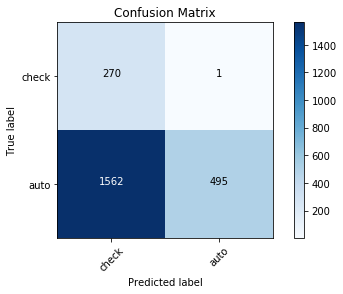

In [23]:
# get confusion matrix for the check/not-check classifier

class_names2 = ["check", "auto"]
y_pred_2c = SVCC.predict(PCAcatsVAL)
# Compute confusion matrix
cnf_matrix = confusion_matrix(inspire_val2['Check'], y_pred_2c)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names2, normalize=False,
                      title='Confusion Matrix')

plt.show()

## DECISION BOUNDARY CUTS

In [69]:
inputs = ['f_core', 'f_noncore', 'f_core_2o',  'f_noncore_2o']
output = ['coreness'] 

In [70]:
f_train = 0.6
f_val   = 0.2
f_test  = 0.2

train_inds = int(f_train*len(inspire))
val_inds   = int((f_val+f_train)*len(inspire))

train = inspire[:][:train_inds]
#y_train = inspire[:][:train]

validation   = inspire[:][val_inds:]#inspire[:][train_inds:val_inds]
#y_val   = inspire[:][train_inds:val_inds]

test  = inspire[:][val_inds:]
#y_test  = inspire[:][val_inds:]


train.head()

,coreness,texts,title unigrams,title bigrams,title trigrams,title quadgrams,abstract unigrams,abstract bigrams,abstract trigrams,abstract quadgrams,category,f_core,f_noncore,f_core_2o,f_noncore_2o,Nrefs,title total,abstract total,234
0,0,The case for absolute ligand discrimination : ...,0,0,0,0,5,0,0,0,q-bio.CB,0.000000,0.014706,0.00000,0.00000,68.0,0,5,0
1,1,On the Distributed Optimization over Directed ...,0,0,0,0,7,0,0,0,math.OC,0.000000,0.000000,0.00000,0.00000,31.0,0,7,0
2,0,Boxy H$\alpha$ Emission Profiles in Star-Formi...,1,0,0,0,12,1,0,1,astro-ph.GA,0.000000,0.615385,0.00108,0.44934,52.0,1,14,2
3,0,Is macroscopic entanglement a typical trait of...,2,0,0,0,5,0,0,0,quant-ph,0.000000,0.083333,0.00668,0.01697,60.0,2,5,0
4,1,The Grism Lens-Amplified Survey from Space (GL...,5,0,0,0,11,3,0,0,astro-ph.GA,0.015385,0.538462,0.00629,0.37929,65.0,5,14,3


In [71]:
x_train = train[inputs]
y_train = train[output].values.flatten()

x_val = validation[inputs]
y_val = validation[output].values.flatten()

x_test = test[inputs]
y_test = test[output].values.flatten()

In [83]:
#get indicies for cross validation
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True) 

In [90]:
# out cross validated accuracy & error
svc = svm.LinearSVC(class_weight='balanced')#svm.SVC(decision_function_shape='ovr', kernel='linear' ,class_weight='balanced', probability=False)#, decision_function_shape='ovr', kernel='rbf')
classifier = svc.fit(x_train, y_train)
svc_score = classifier.score(x_val, y_val)
y_pred_svc = classifier.predict(x_val)
y_crosspred = cross_val_predict(svc,x_train,y_train,cv=kfold)
cv_results = model_selection.cross_val_score(svc, x_train, y_train, cv=kfold, scoring='accuracy') 
print('Accuracy: %0.3f' %cv_results.mean(),'+/- %0.3f' %cv_results.std())

Accuracy: 0.917 +/- 0.003


Normalized confusion matrix
[[0.96 0.04 0.  ]
 [0.35 0.55 0.1 ]
 [0.06 0.05 0.89]]


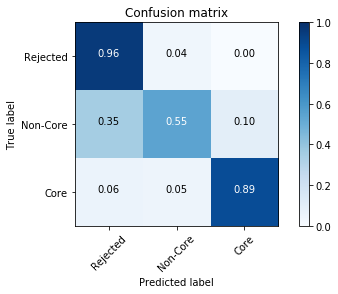

In [91]:
cm_nocuts = confusion_matrix(y_train, y_crosspred) #confusion matrix using cross val predictions with 'training set'
plt.figure()
plot_confusion_matrix(cm_nocuts, class_names, normalize= True)
plt.show()

Normalized confusion matrix
[[0.96 0.04 0.  ]
 [0.35 0.54 0.1 ]
 [0.16 0.13 0.71]]


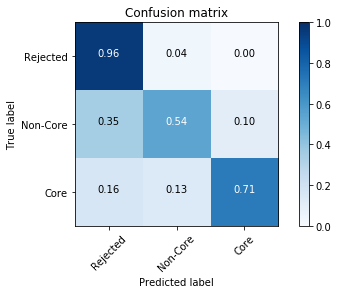

,coreness,texts,title unigrams,title bigrams,title trigrams,title quadgrams,abstract unigrams,abstract bigrams,abstract trigrams,abstract quadgrams,category,f_core,f_noncore,f_core_2o,f_noncore_2o,Nrefs,title total,abstract total,234,Pred
41388,0,Complete population inversion of Bose particle...,1,0,0,0,5,1,0,0,quant-ph,0.0,0.083333,0.00278,0.03889,24.0,1,6,1,0
41389,0,Interval-valued neutrosophic soft sets and its...,0,0,0,0,1,0,0,0,math.GM,0.0,0.000000,0.00000,0.00000,42.0,0,1,0,0
41390,0,Groups acting on trees with almost prescribed ...,2,0,0,0,7,0,0,0,math.GR,0.0,0.000000,0.00000,0.00000,35.0,2,7,0,0
41391,1,Imprints of a high velocity wind on the soft x...,4,0,0,0,12,2,0,0,astro-ph.HE,0.0,0.210526,0.00000,0.07193,19.0,4,14,2,0
41392,0,Ziggurat fringes are self-similar We give expl...,0,0,0,0,3,0,0,0,math.GT,0.0,0.000000,0.00000,0.00000,10.0,0,3,0,0


In [74]:
# performance if you exclude hep categories from validation set
validation['Pred'] = y_pred_svc
no_hep_val=validation.loc[(validation['category'] != 'hep-ph')]
no_hep_val=no_hep_val.loc[(no_hep_val['category'] != 'hep-th')] 
no_hep_val=no_hep_val.loc[(no_hep_val['category'] != 'hep-ex')] 
no_hep_val=no_hep_val.loc[(no_hep_val['category'] != 'hep-lat')] 

cm2 = confusion_matrix(no_hep_val['coreness'], no_hep_val['Pred'])
plt.figure()
plot_confusion_matrix(cm2, class_names, normalize=True)
plt.show()
no_hep_val.head()

In [75]:
# setting up plotting stuff
classes = [0,1,2]
gs = plt.GridSpec(3,6)
ax1_list = [ gs[:2,:2],gs[:2,2:4],gs[:2,4:] ]
ax2_list = [ gs[2:,:2],gs[2:,2:4],gs[2:,4:] ]
color_dict = {0: "royalblue", 1: "darkorange", 2: "g"}
cat_labels={0:"Rej", 1:"NC", 2:"Core"}
fig2_list = [131,132,133]

In [39]:
# function to output the fraction of predicted given truth & fraction of papers you keep & distance bins
def prob_prediction_given_truth(classifier, validation_inputs, validation_outputs, truth, prediction,
                                bins=None, normed=False, N_bins=1000):
    #provide me with a classifier object, and some input data and output data, the predictiuon cstegory you're looking for, and the truth category.
    clf_prediction = classifier.predict(validation_inputs)
    
    ground_truth = validation_outputs
    
    decision_function = classifier.decision_function(validation_inputs)
    w_norm = np.linalg.norm(classifier.coef_,axis=1)
    decision_function = decision_function/w_norm
    
    if normed:
        dist = np.linalg.norm(decision_function, axis=1)
    else:
        dist = decision_function[:,truth]
    
    if bins == None:
        data_range = np.max(dist) - np.min(dist)
        distance_bins = np.linspace(np.min(dist)-data_range/100.0, np.max(dist)+data_range/100.0, N_bins)
    
    sample_true = ground_truth[ ground_truth == truth ]
    sample_pred = clf_prediction[ ground_truth == truth ]
    sample_dist = dist[ ground_truth == truth ]
    
    match_dist = sample_dist[ sample_pred == prediction ]
    
    #print(truth, prediction, len(match_dist), len(sample_dist))
    
    cumulative_all  = np.zeros(N_bins)
    cumulative_match = np.zeros(N_bins)
    
    for i, x in enumerate(distance_bins):
        cumulative_all[i]  = len( sample_dist[sample_dist >= x] )
        cumulative_match[i] = len( match_dist[match_dist >= x] )
        
    fraction_corr = np.nan_to_num( cumulative_match/cumulative_all )
    fraction_keep = np.nan_to_num( cumulative_all/np.max(cumulative_all) )
    
    return fraction_corr, fraction_keep, distance_bins

/Users/parisa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


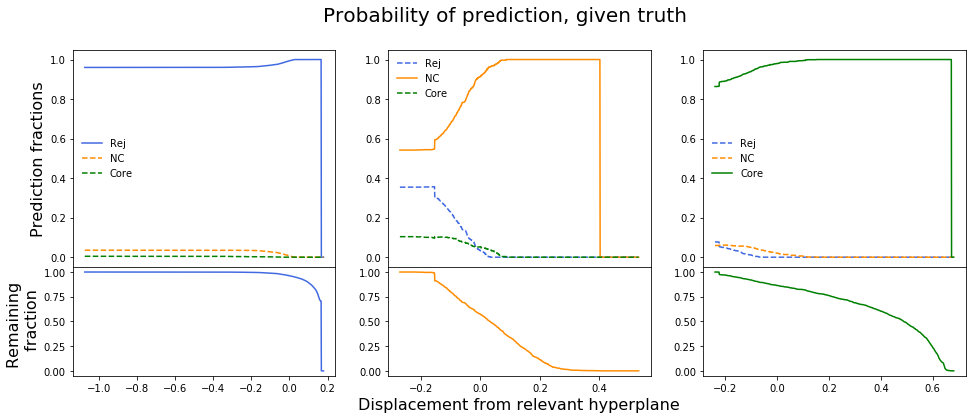

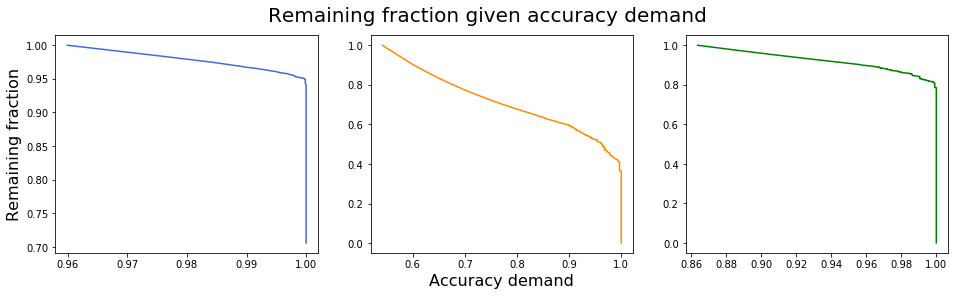

In [77]:
# plot everything
fig = plt.figure(figsize=(16,6))
fig2 = plt.figure(figsize=(16,4))
for i, truth in enumerate([0,1,2]):
    ax1 = fig.add_subplot(ax1_list[i])
    ax2 = fig.add_subplot(ax2_list[i])
    ax3 = fig2.add_subplot(fig2_list[i])
    for j, pred in enumerate([0,1,2]):
        f_match, f_keep, bins = prob_prediction_given_truth(classifier, x_val, y_val, 
                                                           truth=truth, prediction=pred)#, normed=True)        

        line_style = ["-" if truth == pred else "--"][0]

        ax1.plot(bins, f_match, ls=line_style, color=color_dict[pred], label="%s" %cat_labels[pred])
        #ax1.plot(np.full((5,), 0.05),np.linspace(0,1,5),color='k',linestyle='--',alpha=0.5)

        if pred == truth:
            ax2.plot(bins, f_keep, color=color_dict[pred])
            #ax2.plot(np.full((5,), 0.05),np.linspace(0,1,5),color='k',linestyle='--',alpha=1)
            ax3.plot(f_match[f_keep > 0], f_keep[f_keep > 0], color=color_dict[pred])

    if i==0:
        ax1.set_ylabel("Prediction fractions", fontsize=16)
        ax2.set_ylabel("Remaining \n fraction", fontsize=16)
        ax3.set_ylabel("Remaining fraction", fontsize=16)
        
    if i==1:
        ax2.set_xlabel("Displacement from relevant hyperplane", fontsize=16)
        ax3.set_xlabel("Accuracy demand", fontsize=16)
    
    #ax1.semilogy()
    ax1.legend(frameon=False)
fig.suptitle("Probability of prediction, given truth", fontsize=20)
fig.subplots_adjust(hspace=0, wspace=0.5)
#plt.savefig('Probability of prediction, given truth', dpi=200)

fig2.suptitle("Remaining fraction given accuracy demand", fontsize=20)
plt.savefig('Remaining fraction given accuracy demand',dpi=200)
plt.show()

In [78]:
# function to output the fraction of truth given predicted & fraction of papers you keep & distance bins

def prob_truth_given_prediction(classifier, validation_inputs, validation_outputs, truth, prediction,
                                bins=None, normed=False, N_bins=1000):
    
    clf_prediction = classifier.predict(validation_inputs)
    ground_truth = validation_outputs
    
    decision_function = classifier.decision_function(validation_inputs)
    w_norm = np.linalg.norm(classifier.coef_,axis=1)
    decision_function = decision_function/w_norm
    
    if normed:
        dist = np.linalg.norm(decision_function, axis=1)
    else:
        dist = decision_function[:,pred]
    
    if bins == None:
        data_range = np.max(dist) - np.min(dist)
        distance_bins = np.linspace(np.min(dist)-data_range/100.0, np.max(dist)+data_range/100.0, N_bins)
    
    sample_true = ground_truth[ clf_prediction == prediction ]
    sample_pred = clf_prediction[ clf_prediction == prediction ]
    sample_dist = dist[ clf_prediction == prediction ]
    
    match_dist = sample_dist[ sample_true == truth ]
    
    cumulative_all  = np.zeros(N_bins)
    cumulative_match = np.zeros(N_bins)
    
    for i, x in enumerate(distance_bins):
        cumulative_all[i]  = len( sample_dist[sample_dist >= x] )
        cumulative_match[i] = len( match_dist[match_dist >= x] )
        
    fraction_corr = np.nan_to_num( cumulative_match/cumulative_all )
    fraction_keep = np.nan_to_num( cumulative_all/np.max(cumulative_all) )
    
    return fraction_corr, fraction_keep, distance_bins

/Users/parisa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


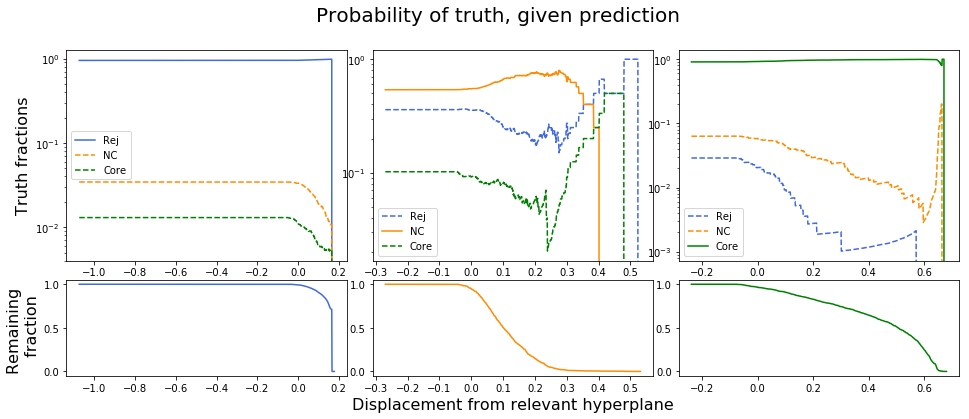

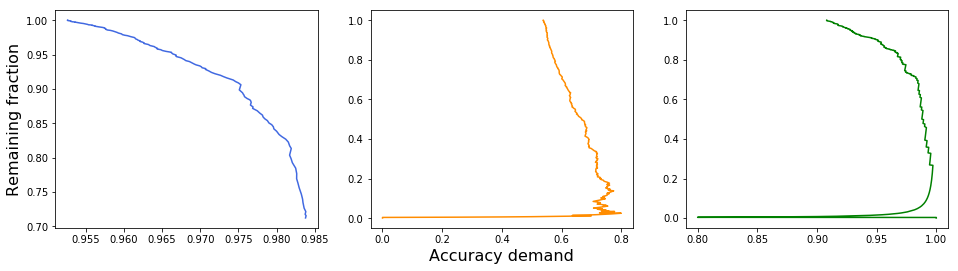

In [79]:
fig = plt.figure(figsize=(16,6))
fig2 = plt.figure(figsize=(16,4))
for i, pred in enumerate([0,1,2]):
    ax1 = fig.add_subplot(ax1_list[i])
    ax2 = fig.add_subplot(ax2_list[i])
    for j, truth in enumerate([0,1,2]):
        f_match, f_keep, bins = prob_truth_given_prediction(classifier, x_val, y_val, 
                                                            truth=truth, prediction=pred)#, normed=True)
        

        line_style = ["-" if truth == pred else "--"][0]

        ax1.plot(bins, f_match, ls=line_style, color=color_dict[truth], label="%s" %cat_labels[truth])

        if pred == truth:
            ax2.plot(bins, f_keep, color=color_dict[truth])   
            
            ax3 = fig2.add_subplot(fig2_list[i])
            ax3.plot(f_match[f_keep > 0], f_keep[f_keep > 0], ls=line_style, color=color_dict[truth])  
            
    if i==0:
        ax1.set_ylabel("Truth fractions", fontsize=16)
        ax2.set_ylabel("Remaining \n fraction", fontsize=16)
        ax3.set_ylabel("Remaining fraction", fontsize=16)
        
    if i==1:
        ax2.set_xlabel("Displacement from relevant hyperplane", fontsize=16)
        ax3.set_xlabel("Accuracy demand", fontsize=16)
            
    ax1.legend()
    ax1.semilogy()

fig.suptitle("Probability of truth, given prediction", fontsize=20)

plt.show()

[False  True  True ... False  True  True]
66.728% of articles are classified with absolute certainty of no false rejections
Confusion matrix, without normalization
[[5833  203    0]
 [  64  359   11]
 [  32   49  354]]


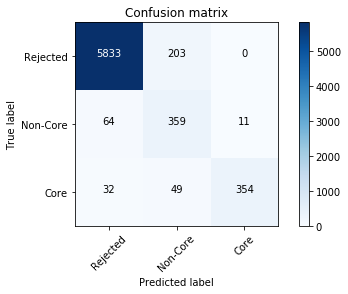

Normalized confusion matrix
[[0.97 0.03 0.  ]
 [0.15 0.83 0.03]
 [0.07 0.11 0.81]]


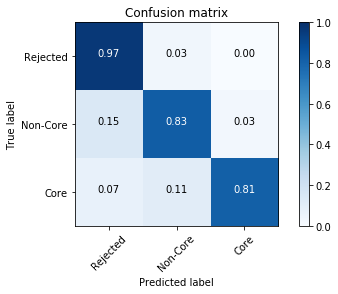

[[ 0.69 -0.58 -0.96]
 [ 0.9  -0.84 -0.97]
 [ 0.9  -0.84 -0.97]
 ...
 [ 0.52 -0.42 -0.95]
 [ 0.9  -0.84 -0.97]
 [ 0.9  -0.84 -0.97]]


In [80]:
# try implementing some distance cuts
rej_cut  = 0.16
NC_cut = 0.05
core_cut = 0.6

decision_function = classifier.decision_function(x_val)
w_norm = np.linalg.norm(classifier.coef_,axis=1)
dec = decision_function/w_norm
prediction = classifier.predict(x_val)

certain_mask = (dec[:,0] > rej_cut) | (dec[:,1] > NC_cut) | (dec[:,2] > core_cut)

print(certain_mask)

certain_true = y_val[ certain_mask ]
certain_pred = prediction[ certain_mask ]
certain_dist = dec[ certain_mask ]

certain_classified_fraction = len(certain_true)/len(x_val)*100

print("%.3f%% of articles are classified" %(certain_classified_fraction))

cm_cut = confusion_matrix(certain_true, certain_pred)
plt.figure()
plot_confusion_matrix(cm_cut, class_names, normalize=False)
plt.show()
plt.figure()
plot_confusion_matrix(cm_cut, class_names, normalize=True)
plt.show()
#plt.savefig('CM_post_cuts_norej',dpi=200, bbox_inches='tight')
print (decision_function)

0
68.891% of articles are classified with absolute certainty of no false rejections
Confusion matrix, without normalization
[[5833  203    0]
 [  64  359   11]
 [  22   48   48]]


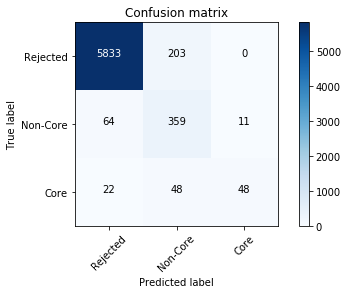

Normalized confusion matrix
[[0.97 0.03 0.  ]
 [0.15 0.83 0.03]
 [0.19 0.41 0.41]]


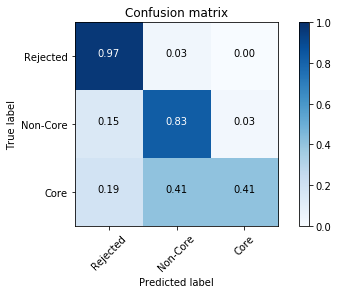

In [81]:
#try excludin hep again

#auto_accept = ['hep-ex','hep-lat','hep-ph','astro-ph.CO','astro-ph.HE','gr-qc', 
              # 'nucl-ex','nucl-th','physics.acc-ph','physics.ins-det','hep-th',
               #'astro-ph.CO','astro-ph.HE','gr-qc','nucl-ex','nucl-th','physics.acc-ph','physics.ins-det',]

auto_accept = ['hep-ex','hep-lat','hep-ph','hep-th']

# Make a mask for all the articles which are NOT hep-ph, etc.
nonauto_mask = np.array([True if validation['category'].values[i] not in auto_accept else False for i,x in enumerate(prediction)])

nonauto_true = y_val[ certain_mask * nonauto_mask]       # False*False = False, Fals
nonauto_pred = prediction[ certain_mask * nonauto_mask ]

print(False*False)

certain_classified_fraction = len(nonauto_true)/len(y_val[ nonauto_mask ])*100
print("%.3f%% of articles are classified" %(certain_classified_fraction))


NA_cm = confusion_matrix(nonauto_true, nonauto_pred)
plt.figure()
plot_confusion_matrix(NA_cm, class_names, normalize=False)
plt.show()

plt.figure()
plot_confusion_matrix(NA_cm, class_names, normalize=True)
plt.show()
#plt.savefig('CM_post_cuts_nohep',dpi=200, bbox_inches='tight')
